In [1]:
import re
import os
from misc import *
import numpy as np
import pandas as pd
import pickle as pkl
import os.path as op
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.stats import ks_2samp, median_test
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import spearmanr, pearsonr, ks_2samp, chisquare, levene

In [2]:
SHAM = "../data/sham_no stimulation/"
vlPFC = "../data/vlPFC_stimulation/"
enc_on = "../data/enc_on_new/"
enc_off = "../data/enc_off_new/"
eng_sham = "../data/Eng_sham/"
eng_vlPFC = "../data/Eng_vlPFC/"

In [3]:
def get_files(x):
    return(
        list(
            filter(lambda x: ".xlsx" in x, [op.join(x, b) for b in [a for a in os.walk(x)][0][2]])
        )
    )

In [4]:
sham_study = sum([Study.load_from_file(a) for a in get_files(SHAM)])
vlPFC_study = sum([Study.load_from_file(a) for a in get_files(vlPFC)])
eon_study = sum([Study.load_from_file(a) for a in get_files(enc_on)])
eoff_study = sum([Study.load_from_file(a) for a in get_files(enc_off)])
esham_study = sum([Study.load_from_file(a) for a in get_files(eng_sham)])
evlPFC_study = sum([Study.load_from_file(a) for a in get_files(eng_vlPFC)])

In [5]:
len(sham_study), len(vlPFC_study), len(eon_study), len(eoff_study)

(29, 27, 28, 31)

In [6]:
sham_exclude = [
    "tDCS3_101_test.xlsx", "tDCS3_103_test.xlsx", "tDCS3_132_test.xlsx", 
    "tDCS3_198_test.xlsx", "tDCS3_209_test.xlsx", "tDCS3_221_test.xlsx"
]
vl_exclude = ["tDCS3_170_test.xlsx", "tDCS3_207_test.xlsx"]
eon_exclude = [
    "tDCS3_110_test (1).xlsx", "tDCS3_114_test (1).xlsx", "tDCS3_113_test (1).xlsx"
]
eoff_exclude = Study.load_from_file(op.join(enc_off, "tDCS3_129_test.xlsx"))
sham_exclude = sum([Study.load_from_file(op.join(SHAM, a)) for a in sham_exclude])
vl_exclude = sum([Study.load_from_file(op.join(vlPFC, a)) for a in vl_exclude])
eon_exclude = sum([Study.load_from_file(op.join(enc_on, a)) for a in eon_exclude])

In [7]:
sham_study = sham_study-sham_exclude
vlPFC_study = vlPFC_study-vl_exclude
eon_study = eon_study-eon_exclude
eoff_study = eoff_study-eoff_exclude

In [8]:
len(sham_study), len(vlPFC_study), len(eon_study), len(eoff_study)

(23, 25, 25, 30)

In [9]:
fnames = [
    "sham_study.pkl", "vlPFC_study.pkl", "eon_study.pkl", "eoff_study.pkl", 
    "esham_study.pkl", "evlPFC_study.pkl"
]
for a,b in zip([sham_study, vlPFC_study, eon_study, eoff_study, esham_study, evlPFC_study], fnames):
    a.save(b)

### Figure 1

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 6
rcParams['font.size'] = 16

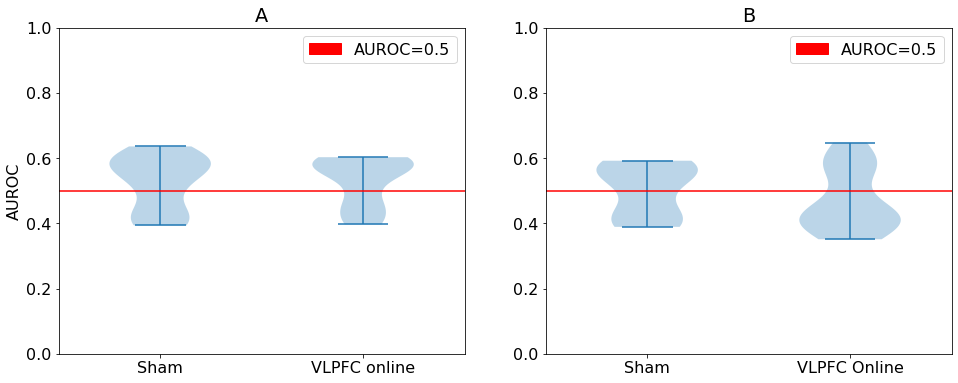

In [11]:
plt.subplot(1,2,1)
plt.title("A")
plt.violinplot(
    [sham_study.compute_study_aucs(), vlPFC_study.compute_study_aucs()]#, eon_auc, eoff_auc]
)
plt.xlim(0.5, 2.5)
plt.xticks([1,2], ["Sham", "VLPFC online"])#, "DLPFC online", "DLPFC offline"])
#plt.grid(True)
plt.ylim(0,1)
plt.ylabel("AUROC")
plt.axhline(y=0.5, xmin=0, xmax=3, color="red")
plt.legend(
    loc="best",
    handles=[Patch(color="red", label="AUROC=0.5")]
)
plt.subplot(1,2,2)
plt.violinplot(
    [esham_study.compute_study_aucs(), evlPFC_study.compute_study_aucs()]
)
plt.xlim(0.5, 2.5)
plt.xticks([1,2], ["Sham", "VLPFC Online"])
#plt.grid(True)
plt.ylim(0,1)
plt.title("B")
#plt.ylabel("AUC")
plt.axhline(y=0.5, xmin=0, xmax=3, color="red")
plt.legend(
    loc="best",
    handles=[Patch(color="red", label="AUROC=0.5")]
)
plt.show()

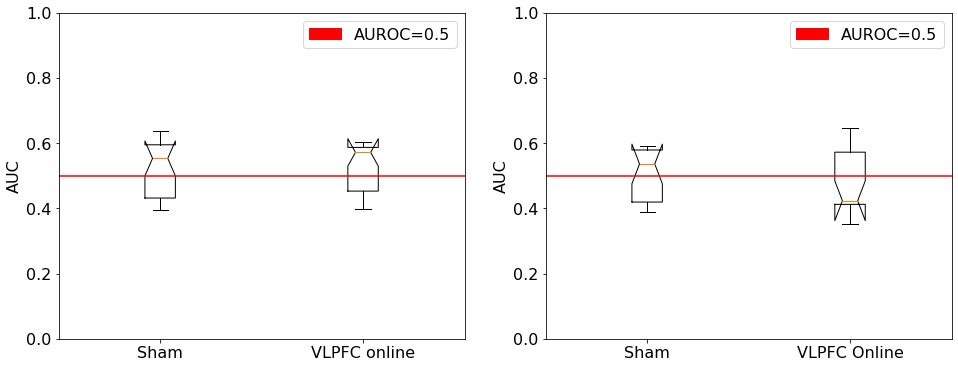

In [12]:
plt.subplot(1,2,1)
plt.boxplot(
    [sham_study.compute_study_aucs(), vlPFC_study.compute_study_aucs()], notch=True#, eon_auc, eoff_auc]
)
plt.legend(
    loc="best",
    handles=[Patch(color="red", label="AUROC=0.5")]
)
plt.xlim(0.5, 2.5)
plt.xticks([1,2], ["Sham", "VLPFC online"])#, "DLPFC online", "DLPFC offline"])
#plt.grid(True)
plt.ylim(0,1)
plt.ylabel("AUC")
plt.axhline(y=0.5, xmin=0, xmax=3, color="red")
plt.subplot(1,2,2)
plt.boxplot(
    [esham_study.compute_study_aucs(), evlPFC_study.compute_study_aucs()], notch=True
)
plt.xlim(0.5, 2.5)
plt.xticks([1,2], ["Sham", "VLPFC Online"])
#plt.grid(True)
plt.ylim(0,1)
plt.legend(
    loc="best",
    handles=[Patch(color="red", label="AUROC=0.5")]
)
plt.ylabel("AUC")
plt.axhline(y=0.5, xmin=0, xmax=3, color="red")
plt.show()

In [13]:
median_test(sham_study.compute_study_aucs(), vlPFC_study.compute_study_aucs())

(0.3339130434782609, 0.5633639803941459, 0.5615925386040328, array([[10, 14],
        [13, 11]]))

### Figure 2

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 10

In [15]:
ru_study = sham_study+vlPFC_study#+eoff_study+eon_study
en_study = esham_study+evlPFC_study

In [16]:
ru_study_all = ru_study+eoff_study+eon_study

In [17]:
ru_study_all.save("ru_study.pkl")
en_study.save("en_study.pkl")

In [18]:
ru_word_aucs = ru_study.compute_word_aucs()
en_word_aucs = en_study.compute_word_aucs()
rusham_word_aucs = sham_study.compute_word_aucs()
esham_word_aucs = esham_study.compute_word_aucs()
ruvlPFC_word_aucs = vlPFC_study.compute_word_aucs()
evlPFC_word_aucs = evlPFC_study.compute_word_aucs()

Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.


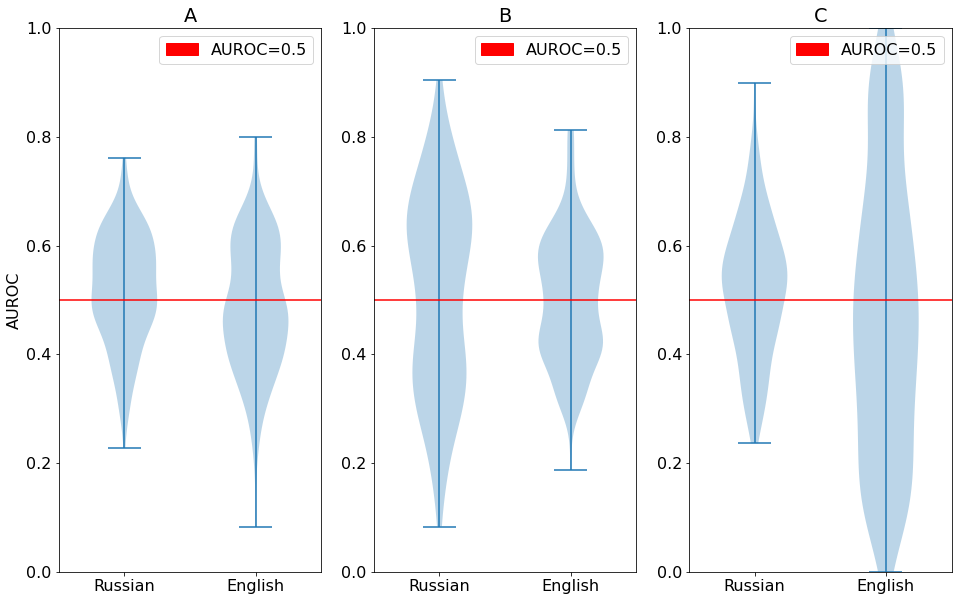

In [19]:
plt.subplot(1,3,1)
plt.title("A")
plt.violinplot(
    [ru_word_aucs["AUROC"], en_word_aucs["AUROC"]]#, eon_auc, eoff_auc]
)
plt.xlim(0.5, 2.5)
plt.xticks([1,2], ["Russian", "English"])#, "DLPFC online", "DLPFC offline"])
#plt.grid(True)
plt.ylim(0,1)
plt.ylabel("AUROC")
plt.axhline(y=0.5, xmin=0, xmax=3, color="red")
plt.legend(
    loc="best",
    handles=[Patch(color="red", label="AUROC=0.5")]
)
plt.subplot(1,3,2)
plt.title("B")
plt.violinplot(
    [rusham_word_aucs["AUROC"], esham_word_aucs["AUROC"]]#, eon_auc, eoff_auc]
)
plt.xlim(0.5, 2.5)
plt.xticks([1,2], ["Russian", "English"])#, "DLPFC online", "DLPFC offline"])
#plt.grid(True)
plt.ylim(0,1)
plt.axhline(y=0.5, xmin=0, xmax=3, color="red")
plt.legend(
    loc="best",
    handles=[Patch(color="red", label="AUROC=0.5")]
)
plt.subplot(1,3,3)
plt.title("C")
plt.violinplot(
    [ruvlPFC_word_aucs["AUROC"], evlPFC_word_aucs["AUROC"]]#, eon_auc, eoff_auc]
)
plt.xlim(0.5, 2.5)
plt.xticks([1,2], ["Russian", "English"])#, "DLPFC online", "DLPFC offline"])
#plt.grid(True)
plt.ylim(0,1)
plt.axhline(y=0.5, xmin=0, xmax=3, color="red")
plt.legend(
    loc="best",
    handles=[Patch(color="red", label="AUROC=0.5")]
)
plt.show()

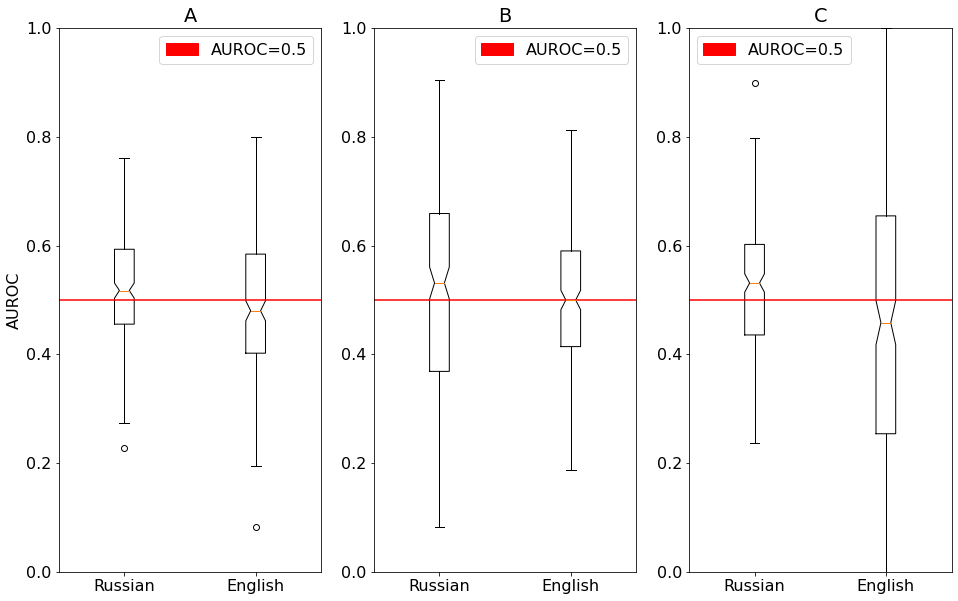

In [20]:
plt.subplot(1,3,1)
plt.title("A")
plt.boxplot(
    [ru_word_aucs["AUROC"], en_word_aucs["AUROC"]], notch=True#, eon_auc, eoff_auc]
)
plt.xlim(0.5, 2.5)
plt.xticks([1,2], ["Russian", "English"])#, "DLPFC online", "DLPFC offline"])
#plt.grid(True)
plt.ylim(0,1)
plt.ylabel("AUROC")
plt.axhline(y=0.5, xmin=0, xmax=3, color="red")
plt.legend(
    loc="best",
    handles=[Patch(color="red", label="AUROC=0.5")]
)
plt.subplot(1,3,2)
plt.title("B")
plt.boxplot(
    [rusham_word_aucs["AUROC"], esham_word_aucs["AUROC"]], notch=True#, eon_auc, eoff_auc]
)
plt.xlim(0.5, 2.5)
plt.xticks([1,2], ["Russian", "English"])#, "DLPFC online", "DLPFC offline"])
#plt.grid(True)
plt.ylim(0,1)
plt.axhline(y=0.5, xmin=0, xmax=3, color="red")
plt.legend(
    loc="best",
    handles=[Patch(color="red", label="AUROC=0.5")]
)
plt.subplot(1,3,3)
plt.title("C")
plt.boxplot(
    [ruvlPFC_word_aucs["AUROC"], evlPFC_word_aucs["AUROC"]], notch=True#, eon_auc, eoff_auc]
)
plt.xlim(0.5, 2.5)
plt.xticks([1,2], ["Russian", "English"])#, "DLPFC online", "DLPFC offline"])
#plt.grid(True)
plt.ylim(0,1)
plt.axhline(y=0.5, xmin=0, xmax=3, color="red")
plt.legend(
    loc="best",
    handles=[Patch(color="red", label="AUROC=0.5")]
)
plt.show()

In [21]:
median_test(ruvlPFC_word_aucs["AUROC"], evlPFC_word_aucs["AUROC"])

(9.593360995850622,
 0.0019528215987615228,
 0.5016233766233766,
 array([[138, 103],
        [103, 138]]))

### Figure 3

In [22]:
ru_word_RTs = ru_study.get_word_RT()
en_word_RTs = en_study.get_word_RT()

In [23]:
ru_RTs = np.array(sum([ru_word_RTs[a] for a in ru_word_RTs], []))
en_RTs = np.array(sum([en_word_RTs[a] for a in en_word_RTs], []))

In [24]:
ru_RTs = ru_study.get_all_RT()
en_RTs = en_study.get_all_RT()

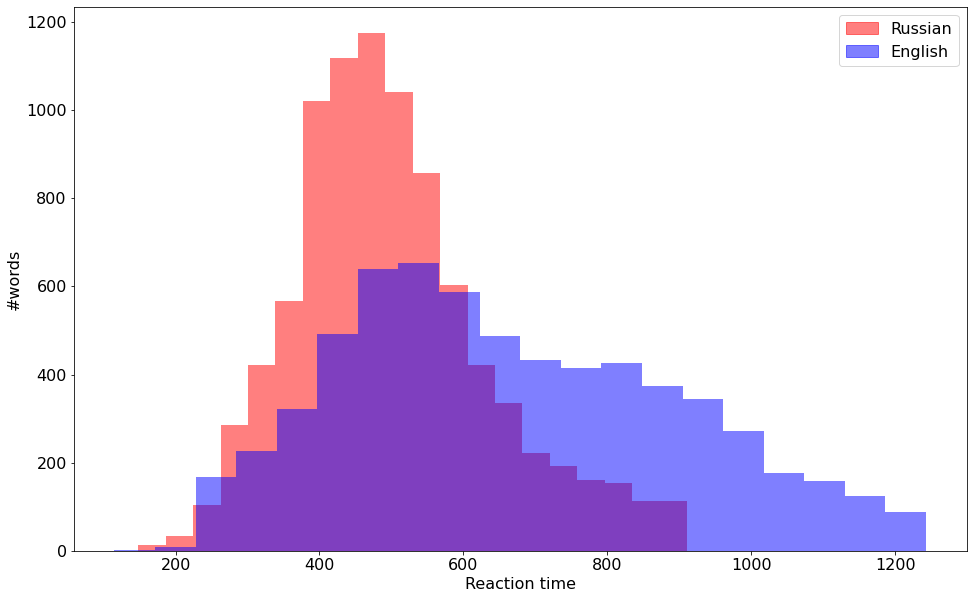

In [25]:
plt.hist(Study.clamp(ru_RTs, 2), bins=20, color=(1,0,0,0.5))
plt.hist(Study.clamp(en_RTs, 2), bins=20, color=(0,0,1,0.5))
plt.legend(
    loc="best",
    handles=[
        Patch(color=(1,0,0,0.5), label="Russian"),
        Patch(color=(0,0,1,0.5), label="English"),
    ]
)
plt.xlabel("Reaction time")
plt.ylabel("#words")
plt.show()

In [26]:
ks_2samp(
    Study.clamp(ru_RTs, 2), Study.clamp(en_RTs, 2)
)

Ks_2sampResult(statistic=0.3577191580344497, pvalue=1.0)

In [27]:
median_test(
    Study.clamp(ru_RTs, 2), Study.clamp(en_RTs, 2)
)

(1458.0887820898974, 0.0, 523.0, array([[3308, 4366],
        [5646, 2035]]))

In [28]:
median_test(
    ru_RTs, en_RTs
)

(1306.2081718354555, 5.059427649268322e-286, 531.0, array([[3596, 4485],
        [5881, 2231]]))